In [110]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

Data Loading

In [111]:
data=pd.read_csv("KDDTrain+.txt")

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted'
    ,'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate'
    ,'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])
data.columns = columns

Data preprocessing

In [112]:
data['attack_num'] = pd.Categorical(data['attack']).codes
data = data.drop(columns='attack')

In [113]:
# One-hot encode the categorical columns
categorical_columns = ['protocol_type', 'service', 'flag']
data = pd.get_dummies(data, columns=categorical_columns)

data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,146,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
2,0,232,8153,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,199,420,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,0,0,0,0,0,0,0,0,0,...,True,False,False,False,False,False,False,False,False,False


Data split

In [114]:
X=data.drop("attack_num",axis=1).values
y=data["attack_num"].values
indices=np.arange(len(X))
np.random.shuffle(indices)
x_shuffle=X[indices]
y_shuffle=y[indices]
split=int(0.8*len(X))
X_train=x_shuffle[:split]
X_test=x_shuffle[split:]
y_train=y_shuffle[:split]
y_test=y_shuffle[split:]

In [115]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [116]:
if isinstance(X_train, np.ndarray):
    X_train = torch.from_numpy(X_train.astype(np.float32))

if isinstance(X_test, np.ndarray):
    X_test = torch.from_numpy(X_test.astype(np.float32))

if isinstance(y_train, np.ndarray):
    y_train = torch.from_numpy(y_train.astype(np.float32))

if isinstance(y_test, np.ndarray):
    y_test = torch.from_numpy(y_test.astype(np.float32))
y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)

Model class

In [117]:
class LogisticRegression(nn.Module):
    def __init__(self, nFeatures, nlabels) -> None:
        super(LogisticRegression,self).__init__()
        self.linear=nn.Linear(nFeatures,nlabels)
    def forward(self,X):
        return self.linear(X)

Model setup

In [118]:
model=LogisticRegression(X_train.shape[1], len(set(y)))
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

In [119]:
y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
y_test = torch.tensor(y_test, dtype=torch.long).squeeze()

<ipython-input-119-ae2856af8b57>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
<ipython-input-119-ae2856af8b57>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).squeeze()


In [120]:
acc = []
loss_y = []
losses=[]
epochs=400
for epoch in range(epochs):
  model.train()
  y_pred=model(X_train)
  loss=criterion(y_pred,y_train)
  losses.append(loss.detach().numpy())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
        y_eval = model.forward(X_test)
  loss_y.append(criterion(y_eval,y_test).detach().numpy())
  correct = 0
  for i,data in enumerate(y_eval):
      if data.argmax().item() == y_test[i]:
          correct += 1
      train_acc = correct/np.size(y_test.detach().numpy())
  acc.append(train_acc)

ploting the accuracy and test loss for each epoch

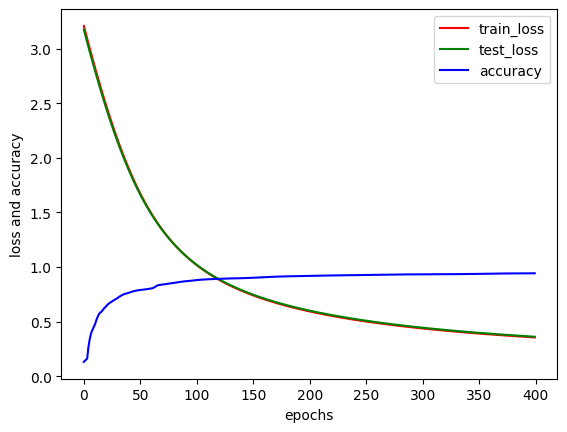

In [121]:
plt.figure()
plt.plot(range(epochs), losses,color='r')
plt.plot(range(epochs), loss_y,color='g')
plt.plot(range(epochs), acc,color='b')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(['train_loss', 'test_loss', 'accuracy'], loc='upper right')
plt.show()

predicting on number of epochs = 300, as the accuracy becomes flat at that point and to avoid overfitting, taking number of epochs as 300

In [122]:
final_model=LogisticRegression(X_train.shape[1], len(set(y)))
final_criterion=nn.CrossEntropyLoss()
final_optimizer=torch.optim.SGD(final_model.parameters(),lr=0.01)


epochs=300
for epoch in range(epochs):
  model.train()
  y_pred=model(X_train)
  loss=criterion(y_pred,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

with torch.no_grad():
      y_eval = model.forward(X_test)
correct = 0
for i,data in enumerate(y_eval):
    if data.argmax().item() == y_test[i]:
        correct += 1
    train_acc = correct/np.size(y_test.detach().numpy())
print(train_acc)

0.9523715022821988


Output metrics

In [126]:
y_test_np = y_test.numpy()
predicted_np = []
for i,data in enumerate(y_eval):
    predicted_np.append(data.argmax().item())
predicted_np = np.array(predicted_np)

In [129]:
accuracy = accuracy_score(y_test_np, predicted_np)
precision = precision_score(y_test_np, predicted_np, average='macro', zero_division=np.nan)
recall = recall_score(y_test_np, predicted_np, average='macro', zero_division=np.nan)
f1 = f1_score(y_test_np, predicted_np, average='macro', zero_division=np.nan)

Accuracy

In [130]:
print(accuracy)

0.9523715022821988


Precision

In [131]:
print(precision)

0.5085400364742462


Recall

In [132]:
print(recall)

0.3474402615304714


F1 score

In [133]:
print(f1)

0.33775539799851395


As the precision, recall and f1_score are low, let's try for boosting

In [135]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [153]:
estimator = LogisticRegression(max_iter=600)
boosted_model = AdaBoostClassifier(estimator=estimator, n_estimators=50)
boosted_model.fit(X_train, y_train)
y_pred = boosted_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [154]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=np.nan)
recall = recall_score(y_test, y_pred, average='macro', zero_division=np.nan)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=np.nan)

In [155]:
print("Boosted")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score : ", f1)

Boosted
Accuracy:  0.9382417146259179
Precision:  0.4726047993228928
Recall:  0.46076050417015607
F1 Score :  0.4048657282906444
